In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32783")
client

<Client: 'tcp://127.0.0.1:32783' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:36413' processes=6 threads=30, memory=118.02 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import gsw
import xrft
import s3fs
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sdir = '/tank/spectre/tuchida/MLI/'

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [54]:
reg = 1
dss = cat.eNATL60(region=str(reg),datatype='surface_hourly', season='fma'
                 ).to_dask()
dss.coords['day'] = ('time_counter',np.repeat(np.arange(len(dss.time_counter)//24),
                                              24))
dss = dss.groupby('day').mean('time_counter',skipna=True)

dss

<xarray.Dataset>
Dimensions:   (y: 763, x: 611, day: 89)
Coordinates: (12/14)
    depth     (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...        ...
    e2v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    qt_oce    (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...        ...
    sowaflup  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    umask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    vmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>

In [55]:
dsi = cat.eNATL60(region=str(reg),datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 763, x: 611, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [56]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [57]:
taux = xr.DataArray(dss.sozotaux.data, dims=['time','YC','XG'],
                    coords={'YC':YC.data,'XG':XG.data}
                   )
tauy = xr.DataArray(dss.sometauy.data, dims=['time','YG','XC'],
                    coords={'YG':YG.data,'XC':XC.data}
                   )
fwf  = xr.DataArray(dss.sowaflup.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )
Q    = xr.DataArray(dss.qt_oce.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

In [58]:
v  = xr.DataArray(dsi.vomecrty.data, dims=['time','Z','YG','XC'],
                  coords={'Z':dsi.depthv.data,'YG':YG.data,'XC':XC.data}
                 )
u  = xr.DataArray(dsi.vozocrtx, dims=['time','Z','YC','XG'],
                  coords={'Z':dsi.depthu.data,'YC':YC.data,'XG':XG.data}
                 )
w  = xr.DataArray(dsi.vovecrtz.data, dims=['time','Zp1','YC','XC'],
                  coords={'Zp1':dsi.depthw.data,'YC':YC.data,'XC':XC.data}
                 )
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [59]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA
ds['U'] = u
ds['V'] = v
ds['W'] = w
ds['taux'] = taux  # N/m2 = (kg.m/s2)/m2
ds['tauy'] = tauy  # N/m2
ds['Ffw'] = fwf    # kg/m2/s
ds['Q'] = Q        # W/m2 = (N.m/s)/m2 = (kg.m2/s3)/m2
ds.coords['lat'] = xr.DataArray(dsi.lat.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['lon'] = xr.DataArray(dsi.lon.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds.coords['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds.coords['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )
ds = ds.chunk({'time':1,'YC':100,'XC':100})

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  "outer":"Zp1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center

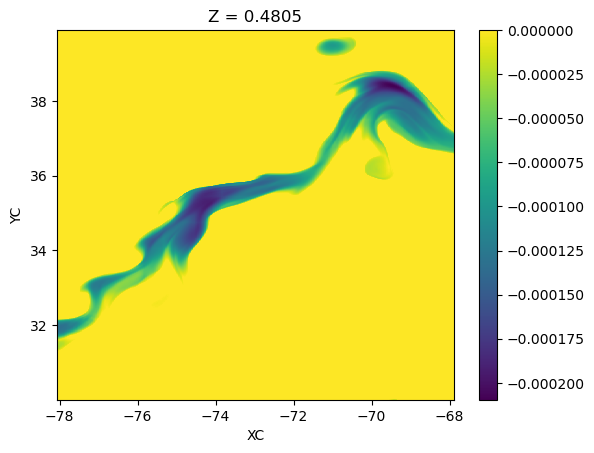

In [60]:
alpha = xr.apply_ufunc(gsw.alpha,  # 1/K
                       SA.isel(Z=0), CT.isel(Z=0), 0., 
                       dask='parallelized'
                      ) 
Cp = 1005.
rho_air = 1.225
grav = 9.81
B0 = grav*alpha * (ds.Q/rho_air/Cp)
B0 = B0.where(B0<0.).fillna(0.)
B0.isel(time=62).plot()

In [61]:
rho0 = 1000.
ustar = np.sqrt(np.sqrt(grid.interp(ds.taux**2,'X',boundary='extend') 
                        + grid.interp(ds.tauy**2,'Y',boundary='extend')
                       )
                / rho0)

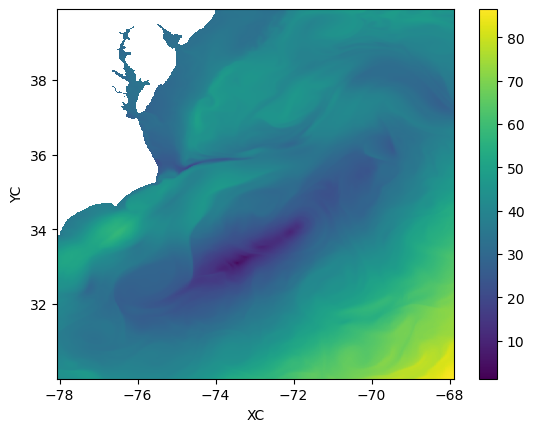

In [62]:
f = xr.apply_ufunc(gsw.f, xr.DataArray(dss.nav_lat.data, dims=['YC','XC'],
                                       coords={'YC':ds.YC,'XC':ds.XC}),
                   dask='parallelized'
                  )
hE = (.7*ustar / f)
hE.isel(time=62).plot()

In [63]:
wstar = (-B0/hE)**(1/3)

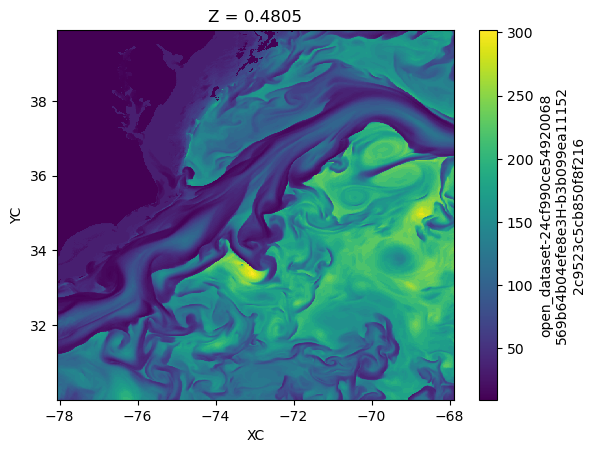

In [64]:
dz = xr.DataArray(dsi.e3t_0.mean(['y','x']).data, dims='Z',
                  coords={'Z':ds.Z}
                 ).load()
H = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/MLD_fma.zarr' 
                         % reg)
                ).H.reset_coords(drop=True)
H = xr.DataArray(H.data, dims=ds.CT.isel(Z=0).dims, coords=ds.CT.isel(Z=0).coords)
H.isel(time=0).plot()

In [ ]:
# pres = xr.apply_ufunc(gsw.p_from_z, -ds.Zp1, ds.lat, dask='parallelized'
#                      ).compute()
# for i in range(len(ds.time)):
#     n2, _ = gsw.Nsquared(
#                      grid.interp(ds.SA.isel(time=i).chunk({'Z':-1}),'Z',boundary='extend'),
#                      grid.interp(ds.CT.isel(time=i).chunk({'Z':-1}),'Z',boundary='extend'),
#                      pres,
#                      lat=ds.lat, axis=0
#                         )
#     if i == 0:
#         N2 = xr.DataArray(n2, dims=ds.CT.isel(time=i).dims, 
#                           coords=ds.CT.isel(time=i).coords
#                          ).chunk({'Z':3,'YC':100,'XC':100})
#     else:
#         N2 = xr.concat([N2, xr.DataArray(n2, dims=ds.CT.isel(time=i).dims, 
#                                          coords=ds.CT.isel(time=i).coords
#                                         ).chunk({'Z':3,'YC':100,'XC':100})
#                        ], 'time')
#     print(i)
# N2.chunk({'time':1}).to_dataset(name='N2'
#                                ).to_zarr(op.join(sdir,'eNATL60/region%02d/N2_fma.zarr' 
#                          % reg))
# ################
N2 = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/N2_fma.zarr' 
                          % reg)
                 ).N2

N2 = ((N2 * dz).where(N2.Z<=H).sum('Z',skipna=True) / H).compute().chunk({'time':1})
N2

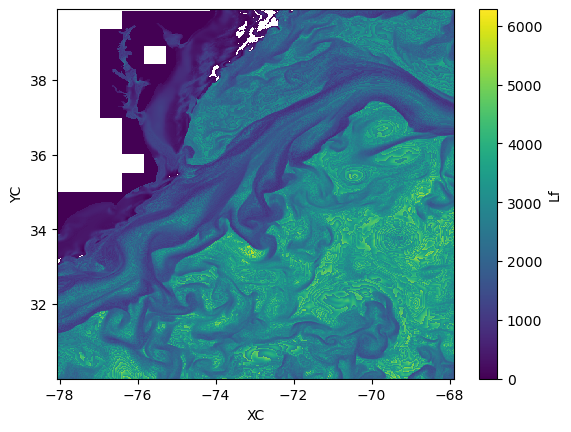

In [65]:
Cl = .25
mstar = .5
nstar = .066

# Lf_old = np.sqrt(N2) * H / f
# Lf_old.chunk({'time':1,'YC':100,'XC':100}
#             ).to_dataset(name='Lf').to_zarr(op.join(sdir,
#                                                 'eNATL60/region%02d/MLradii_fma.zarr' 
#                           % reg), mode='w')
Lf_old = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/MLradii_fma.zarr' 
                              % reg)).Lf
Lf_new = (mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hE
Lf_old.isel(time=0).plot()

In [ ]:
sig0 = xr.apply_ufunc(gsw.sigma0, ds.SA, ds.CT,
                      dask='parallelized', output_dtypes=[float,]
                     )
rho0 = 1e3
b = -(sig0.where(ds.maskC!=0.).chunk({'time':1,'Z':3,
                                      'YC':100,'XC':100}) 
      * grav / rho0
     )
b.to_dataset(name='BUOY').to_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                                          % reg))

In [66]:
b = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                         % reg)
                ).BUOY
w = grid.interp(ds.W.chunk({'Zp1':-1}),'Z',boundary='extend'
               ).chunk({'time':1,'Z':3,'YC':100,'XC':100})
area = xr.DataArray((dss.e1t * dss.e2t).data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

# Reynold's decomposition
## $$ \overline{w'b'}^z = \overline{wb}^z - \overline{w}^z\overline{b}^z $$

In [18]:
nC = 6
yC = ds.YC.coarsen({'YC':nC},boundary='trim').mean(skipna=True)
xC = ds.XC.coarsen({'XC':nC},boundary='trim').mean(skipna=True)
yG = ds.YG.coarsen({'YG':nC},boundary='trim').mean(skipna=True)
xG = ds.XG.coarsen({'XG':nC},boundary='trim').mean(skipna=True)
aC = area.where(ds.maskC!=0.).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                     ).sum(skipna=True).compute()

fb = xr.DataArray(xr.apply_ufunc(gsw.f, 
                    (xr.DataArray(dss.nav_lat.data, dims=['YC','XC'],
                                  coords={'YC':ds.YC,'XC':ds.XC})
                     * area
                    ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                    / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                   dask='parallelized'
                  ).data,  dims=['YC','XC'],
                 coords={'YC':yC,'XC':xC}
                )

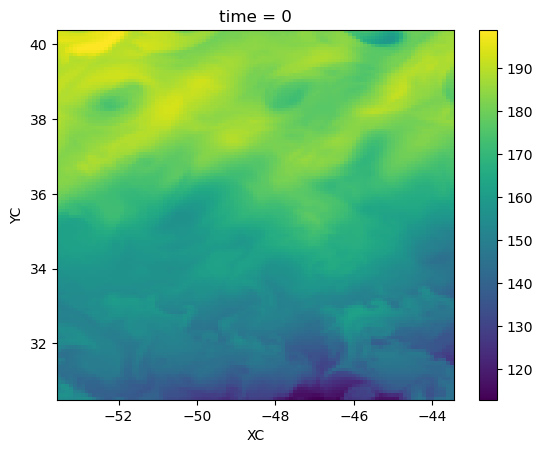

In [19]:
Lfb = xr.DataArray((Lf_new*area).where(ds.maskC.isel(Z=0)!=0
                                      ).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                               ).sum(skipna=True)
                  / aC.isel(Z=0),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
Hb = xr.DataArray((H*area).where(ds.maskC.isel(Z=0)!=0
                                      ).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                               ).sum(skipna=True)
                  / aC.isel(Z=0),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
(Lfb).isel(time=0).plot()

In [21]:
B = xr.DataArray((b * area).where(ds.maskC!=0.).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                                      ).sum(skipna=True)
                 / aC,
                 dims=['time','Z','YC','XC'], 
                 coords={'time':ds.time,'Z':ds.Z,'YC':yC,'XC':xC}
     )
W = xr.DataArray((w * area).where(ds.maskC!=0.).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                                      ).sum(skipna=True)
                 / aC,
                 dims=['time','Z','YC','XC'], 
                 coords={'time':ds.time,'Z':ds.Z,'YC':yC,'XC':xC}
     )
WB = xr.DataArray((w * b * area
                  ).where(ds.maskC!=0.).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                               ).sum(skipna=True)
                  / aC,
                  dims=['time','Z','YC','XC'], 
                  coords={'time':ds.time,'Z':ds.Z,'YC':yC,'XC':xC}
      )
dsave = B.to_dataset(name='BUOY')
dsave['WVEL'] = W
dsave['WB'] = WB
dsave.chunk({'time':1,'Z':1,'YC':-1,'XC':-1}
           ).to_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/Reynolds_fma.zarr' 
                             % reg), mode='w')

print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:  (time: 89, Z: 106, YC: 122, XC: 101)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * Z        (Z) float32 0.4805 1.559 2.794 4.187 ... 934.9 951.6 968.4 985.3
  * YC       (YC) float32 30.54 30.63 30.71 30.8 ... 40.11 40.19 40.26 40.34
  * XC       (XC) float32 -53.52 -53.42 -53.32 -53.22 ... -43.7 -43.6 -43.5
Data variables:
    BUOY     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 3, 16, 16), meta=np.ndarray>
    WVEL     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 3, 16, 16), meta=np.ndarray>
    WB       (time, Z, YC, XC) float64 dask.array<chunksize=(1, 3, 16, 16), meta=np.ndarray>


In [20]:
dsr = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/Reynolds_fma.zarr' 
                           % reg))
Bb  = ((dsr.BUOY * dz).where(dsr.BUOY.Z<=np.abs(Hb)).sum('Z',skipna=True) 
       / np.abs(Hb)
      ).compute().chunk({'time':1})
Wb  = ((dsr.WVEL * dz).where(dsr.WVEL.Z<=np.abs(Hb)).sum('Z',skipna=True) 
       / np.abs(Hb)
      ).compute().chunk({'time':1})
WBb = ((dsr.WB * dz).where(dsr.BUOY.Z<=np.abs(Hb)).sum('Z',skipna=True) 
       / np.abs(Hb)
      ).compute().chunk({'time':1})
wbb = WBb - Wb*Bb
wbb

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(


<xarray.DataArray (time: 89, YC: 122, XC: 101)>
dask.array<sub, shape=(89, 122, 101), dtype=float64, chunksize=(1, 122, 101), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 -53.52 -53.42 -53.32 -53.22 ... -43.7 -43.6 -43.5
  * YC       (YC) float32 30.54 30.63 30.71 30.8 ... 40.11 40.19 40.26 40.34
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88

In [21]:
dxu = xr.DataArray(dss.e1u.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dyu = xr.DataArray(dss.e2u.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dxv = xr.DataArray(dss.e1v.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dyv = xr.DataArray(dss.e2v.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dxt = xr.DataArray(dss.e1t.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dyt = xr.DataArray(dss.e2t.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dxf = xr.DataArray(dss.e1f.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )
dyf = xr.DataArray(dss.e2f.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )

In [22]:
dsC = Bb.to_dataset(name='BUOY')
# dsC['WVEL'] = Wb
dsC['wb'] = wbb
dsC.coords['YG'] = yG
dsC.coords['XG'] = xG
dsC.coords['DXU'] = dxu
dsC.coords['DYV'] = dyv
dsC.coords['DXV'] = dxv
dsC.coords['DYU'] = dyu
dsC.coords['DXT'] = dxt
dsC.coords['DYT'] = dyt
dsC.coords['DXF'] = dxf
dsC.coords['DYF'] = dyf
dsC

<xarray.Dataset>
Dimensions:  (XC: 101, YC: 122, time: 89, YG: 122, XG: 101)
Coordinates: (12/13)
  * XC       (XC) float32 -53.52 -53.42 -53.32 -53.22 ... -43.7 -43.6 -43.5
  * YC       (YC) float32 30.54 30.63 30.71 30.8 ... 40.11 40.19 40.26 40.34
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * YG       (YG) float32 30.53 30.62 30.7 30.79 ... 40.11 40.18 40.26 40.33
  * XG       (XG) float32 -53.53 -53.43 -53.33 -53.23 ... -43.71 -43.61 -43.51
    DXU      (YC, XG) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    ...       ...
    DXV      (YG, XC) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    DYU      (YC, XG) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    DXT      (YC, XC) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    DYT      (YC, XC) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    DXF      (YG, XG) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
    DYF      (YG, XG) float64 dask.array<chunksize=(122, 101), meta=np.ndarray>
Data variables:
    BUOY     (time, YC, XC) float64 dask.array<chunksize=(1, 122, 101), meta=np.ndarray>
    wb       (time, YC, XC) float64 dask.array<chunksize=(1, 122, 101), meta=np.ndarray>

In [23]:
coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
gridC = Grid(dsC, periodic=[],
             coords=coords)
gridC

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [24]:
B_x = ((gridC.interp(gridC.diff(dsr.BUOY,'X',boundary='extend') 
                     / dsC.DXU,
                     'X',boundary='extend')
        * dz).where(dsr.BUOY.Z<=np.abs(Hb)).sum('Z',skipna=True) 
       / np.abs(Hb)).compute().chunk({'time':1})
B_y = ((gridC.interp(gridC.diff(dsr.BUOY,'Y',boundary='extend') 
                     / dsC.DYV,
                     'Y',boundary='extend')
        * dz).where(dsr.BUOY.Z<=np.abs(Hb)).sum('Z',skipna=True) 
       / np.abs(Hb)).compute().chunk({'time':1})

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(


KilledWorker: Attempted to run task ('mul-172b7d4064d375944235b4a3cc975db7', 11, 19, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38951. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [95]:
dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.DataArray(np.zeros_like(dss.sosstsst.isel(day=0)),
                        dims=['YC','XC'],
                        coords={'YC':YC.data,
                                'XC':XC.data}
           )
wet_mask[1:-1,1:-1] = dsi.tmask[0,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [96]:
Bm = filter_30km.apply(B.chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

In [97]:
B_x = grid.interp(grid.diff(Bm,'X',boundary='extend') 
                  / dss.e1u.data[np.newaxis],
                  'X',boundary='extend')
B_y = grid.interp(grid.diff(Bm,'Y',boundary='extend') 
                  / dss.e2v.data[np.newaxis],
                  'Y',boundary='extend')

In [ ]:
Psix = np.sqrt(aC.isel(Z=0))/Lfb/fb * Hb**2 * B_y
Psiy = np.sqrt(aC.isel(Z=0))/Lfb/fb * Hb**2 * (-B_x)
Psix

In [ ]:
Db = xr.DataArray((dss.depth.data
                   * area).where(ds.maskC.isel(Z=0)!=0.
                                ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                  / aC.isel(Z=0),
                  dims=['YC','XC'], 
                  coords={'YC':yC,'XC':xC}
     ).compute()
bff = (Psix*B_y - Psiy*B_x)
bff

In [ ]:
Cr = (WBb / bff).where(Db>2e2)
Cr.isel(time=0).plot(vmax=1e2)

In [ ]:
CrC = Cr.chunk({'YC':-1,'XC':-1}).median(['YC','XC'],skipna=True).compute()

In [ ]:
time = np.arange('2010-02-01', '2010-05-01', dtype='datetime64[D]')

fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
# ax2 = ax.twinx()
ax.plot(range(89), CrC.values, 'k', label=r"$C_r(t)$")
# ax2.plot(range(89), CrC.values, 'r--', label=r"$C_r(t)$")
ax.set_xticks(np.arange(89)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
# ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
# ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
# ax2.spines['right'].set_color('red')
# ax.legend(loc='lower left', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"$C_r(t)$", fontsize=13)
# ax2.set_ylabel(r"$C_r(t)$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/eNATL60_Reynolds_region%02d_Cs.pdf' % reg))

In [ ]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

dsC.wb.where(Db>200.).isel(time=0).plot(ax=axes[0,0], vmax=2e-6, cmap='RdBu_r', rasterized=True)
(Cr*bff).where(Db>200.).isel(time=0).plot(ax=axes[0,1], vmax=2e-6, cmap='Reds', rasterized=True)
WBb.where(Db>200.).isel(time=0).plot(ax=axes[1,0], vmax=6e-5, cmap='RdGy_r', rasterized=True)
(Wb*Bb).where(Db>200.).isel(time=0).plot(ax=axes[1,1], vmax=6e-5, cmap='RdGy_r', rasterized=True)

axes[0,0].set_title(r"$\overline{w'b'}^{zyx}$", fontsize=14)
axes[0,1].set_title(r"$C_r(\Psi^{Bodner}\times\nabla\overline{b}^{zyx})$", fontsize=14)
axes[1,0].set_title(r"$\overline{wb}^{zyx}$", fontsize=14)
axes[1,1].set_title(r"$\overline{w}^{zyx}\overline{b}^{zyx}$", fontsize=14)
plt.savefig(op.join(sdir,'Figs/eNATL60_Reynolds_region%02d.pdf' % reg))

# Filter, then coarsen

In [67]:
nC = 6
yC = ds.YC.isel(YC=slice(1,-1)).coarsen({'YC':nC},boundary='trim').mean(skipna=True)
xC = ds.XC.isel(XC=slice(1,-1)).coarsen({'XC':nC},boundary='trim').mean(skipna=True)
yG = ds.YG.isel(YG=slice(1,-1)).coarsen({'YG':nC},boundary='trim').mean(skipna=True)
xG = ds.XG.isel(XG=slice(1,-1)).coarsen({'XG':nC},boundary='trim').mean(skipna=True)
aC = area.where(ds.maskC!=0.).isel(YC=slice(1,-1),XC=slice(1,-1)
                                  ).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                           ).sum(skipna=True).compute()

In [20]:
dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.zeros_like(ds.CT.isel(time=0)
           ).chunk({'Z':1})
wet_mask[:,1:-1,1:-1] = dsi.tmask[:,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_s[:,1:-1,1:-1] += 1.


filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [21]:
wm = filter_30km.apply(w.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
bm = filter_30km.apply(b.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
dsave = wm.to_dataset(name='WVEL')
dsave['BUOY'] = bm
dsave.to_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                      % reg), mode='w')

In [19]:
dsm = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                           % reg))
ws = (w.isel(YC=slice(1,-1),XC=slice(1,-1))
      - dsm.WVEL).reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
bs = (b.isel(YC=slice(1,-1),XC=slice(1,-1)) 
      - dsm.BUOY).reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
bs

<xarray.DataArray 'BUOY' (time: 89, Z: 106, YC: 733, XC: 605)>
dask.array<rechunk-merge, shape=(89, 106, 733, 605), dtype=float64, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 -53.54 -53.53 -53.51 -53.49 ... -43.49 -43.48 -43.46
  * YC       (YC) float32 30.52 30.53 30.55 30.56 ... 40.36 40.37 40.38 40.4
  * Z        (Z) float32 0.4805 1.559 2.794 4.187 ... 934.9 951.6 968.4 985.3
Dimensions without coordinates: time

In [21]:
dt = 1
for i in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    wsbs = ((((ws*bs).isel(time=i)
              * dz
             ).where(ds.Z<=H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1)))
            ).sum('Z',skipna=True)
            / H.isel(time=i,YC=slice(1,-1),XC=slice(1,-1))
           ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
    if i == 0:
        wsbsb = xr.DataArray(((wsbs
                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC.isel(Z=0)
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()
    else:
        wsbsb = xr.concat([wsbsb, 
                           xr.DataArray(((wsbs
                                          * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                      ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                      / aC.isel(Z=0)
                     ).data,
                     dims=['YC','XC'], 
                     coords={'YC':yC,'XC':xC}
          ).compute()], 'time')
    print(i)

wsbsb.to_dataset(name='WsBs').chunk({'time':1}
                                   ).to_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/WsBsH.zarr' 
                                                     % reg),
                                             mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [22]:
dt = 1
for i in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    if i == 0:
        bmb = xr.DataArray(((dsm.BUOY.isel(time=i)
                             * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                    ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                    / aC
                   ).data,
                   dims=['Z','YC','XC'], 
                   coords={'Z':ds.Z,'YC':yC,'XC':xC}
        ).compute().chunk({'YC':-1,'XC':-1,'Z':3})
    else:
        bmb = xr.concat([bmb,
                         xr.DataArray(((dsm.BUOY.isel(time=i)
                                        * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                    ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
                    / aC
                   ).data,
                   dims=['Z','YC','XC'], 
                   coords={'Z':ds.Z,'YC':yC,'XC':xC}
        ).compute().chunk({'YC':-1,'XC':-1,'Z':3})], 'time')
    print(i)

bmb.to_dataset(name='BUOY').chunk({'time':1}
                                 ).to_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/Bm.zarr' 
                                                   % reg),
                                           mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [68]:
dsC = xr.merge([xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/Bm.zarr' % reg)
                            ),
                xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Coarse/WsBsH.zarr' % reg)
                            )
               ])
dsC

<xarray.Dataset>
Dimensions:  (time: 89, Z: 106, YC: 126, XC: 101)
Coordinates:
  * XC       (XC) float32 -78.0 -77.9 -77.8 -77.7 ... -68.21 -68.11 -68.01
  * YC       (YC) float32 30.06 30.14 30.23 30.31 ... 39.57 39.64 39.71 39.78
  * Z        (Z) float32 0.4805 1.559 2.794 4.187 ... 934.9 951.6 968.4 985.3
Dimensions without coordinates: time
Data variables:
    BUOY     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 3, 126, 101), meta=np.ndarray>
    WsBs     (time, YC, XC) float64 dask.array<chunksize=(1, 126, 101), meta=np.ndarray>

In [69]:
lonC = ((xr.DataArray(dss.lon.data, dims=['YC','XC'],
                      coords={'YC':ds.YC,'XC':ds.XC}
                     ) * area
        ).isel(YC=slice(1,-1),XC=slice(1,-1)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
        / area.isel(YC=slice(1,-1),XC=slice(1,-1)
                   ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
       )
latC = ((xr.DataArray(dss.lat.data, dims=['YC','XC'],
                      coords={'YC':ds.YC,'XC':ds.XC}
                     ) * area
        ).isel(YC=slice(1,-1),XC=slice(1,-1)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
        / area.isel(YC=slice(1,-1),XC=slice(1,-1)
                   ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
       )
fb = xr.DataArray(xr.apply_ufunc(gsw.f, latC,
                                 dask='parallelized'
                                ).data, 
                  dims=['YC','XC'],
                  coords={'YC':yC,'XC':xC}
                 )
dsC.coords['DXU'] = xr.DataArray(dss.e1u.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dsC.coords['DYU'] = xr.DataArray(dss.e2u.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dsC.coords['DXV'] = xr.DataArray(dss.e1v.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dsC.coords['DYV'] = xr.DataArray(dss.e2v.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dsC.coords['DXT'] = xr.DataArray(dss.e1t.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dsC.coords['DYT'] = xr.DataArray(dss.e2t.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dsC.coords['DXF'] = xr.DataArray(dss.e1f.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )
dsC.coords['DYF'] = xr.DataArray(dss.e2f.isel(y=slice(1,-1),x=slice(1,-1)
                                             ).coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )

In [70]:
coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
gridC = Grid(dsC, periodic=[],
             coords=coords)

In [71]:
Hb = xr.DataArray((H*area).where(ds.maskC.isel(Z=0)!=0.
                                ).isel(YC=slice(1,-1),XC=slice(1,-1)
                               ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / aC.isel(Z=0),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Lf_oldb = xr.DataArray((Lf_old*area).where(ds.maskC.isel(Z=0)!=0.)
                       .isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / aC.isel(Z=0),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Lf_newb = xr.DataArray((Lf_new*area).where(ds.maskC.isel(Z=0)!=0.)
                       .isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / aC.isel(Z=0),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})
Db = xr.DataArray((dss.depth.data
                   * area).where(ds.maskC.isel(Z=0)!=0.
                                ).isel(YC=slice(1,-1),XC=slice(1,-1)
                                            ).coarsen({'YC':nC,'XC':nC},boundary='trim'
                                                     ).sum(skipna=True)
      / aC.isel(Z=0),
                  dims=['YC','XC'], 
                  coords={'YC':yC,'XC':xC}
     ).chunk({'YC':-1,'XC':-1})

B_x = ((gridC.interp(gridC.diff(dsC.BUOY,'X',boundary='extend') 
                     / dsC.DXU,
                     'X',boundary='extend')
        * dz
       ).where(dsC.Z<=Hb).sum('Z',skipna=True).reset_coords(drop=True).chunk({'YC':-1,'XC':-1})
       / Hb)
B_y = ((gridC.interp(gridC.diff(dsC.BUOY,'Y',boundary='extend') 
                     / dsC.DYV,
                     'Y',boundary='extend')
        * dz
       ).where(dsC.Z<=Hb).sum('Z',skipna=True).reset_coords(drop=True).chunk({'YC':-1,'XC':-1}) 
       / Hb)

In [72]:
Psix_old = np.sqrt(aC.isel(Z=0))/Lf_oldb/fb * Hb**2 * B_y
Psiy_old = np.sqrt(aC.isel(Z=0))/Lf_oldb/fb * Hb**2 * (-B_x)
Psix_new = np.sqrt(aC.isel(Z=0))/Lf_newb/fb * Hb**2 * B_y
Psiy_new = np.sqrt(aC.isel(Z=0))/Lf_newb/fb * Hb**2 * (-B_x)
Psix_old

<xarray.DataArray (YC: 126, XC: 101, time: 89)>
dask.array<mul, shape=(126, 101, 89), dtype=float64, chunksize=(126, 101, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 30.06 30.14 30.23 30.31 ... 39.57 39.64 39.71 39.78
  * XC       (XC) float32 -78.0 -77.9 -77.8 -77.7 ... -68.21 -68.11 -68.01
    Z        float32 0.4805
    lat      (YC, XC) float32 30.05 30.05 30.05 30.05 ... 39.89 39.89 39.89
    lon      (YC, XC) float32 -77.95 -77.85 -77.75 ... -68.31 -68.21 -68.11
    maskC    (YC, XC) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88

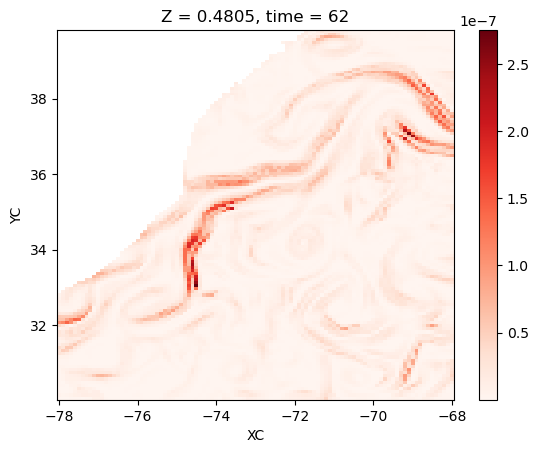

In [73]:
bff = (Psix_old*B_y - Psiy_old*B_x)
bod = (Psix_new*B_y - Psiy_new*B_x)
bff.where(Db>2e2).isel(time=62).plot(cmap='Reds')

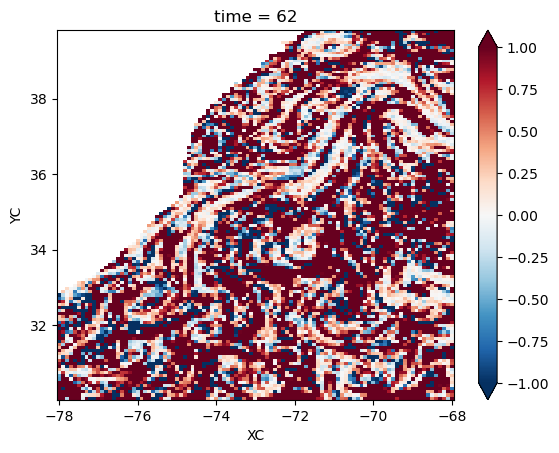

In [74]:
Ce = (dsC.WsBs / bff).where(Db>2e2).reset_coords(drop=True)
Cr = (dsC.WsBs / bod).where(Db>2e2).reset_coords(drop=True)
Ce.isel(time=62).plot(vmax=1e0)

In [75]:
CeC = Ce.median(['YC','XC'],skipna=True).compute()
CrC = Cr.median(['YC','XC'],skipna=True).compute()

In [76]:
time = np.arange('2010-02-01', '2010-05-01', dtype='datetime64[D]')

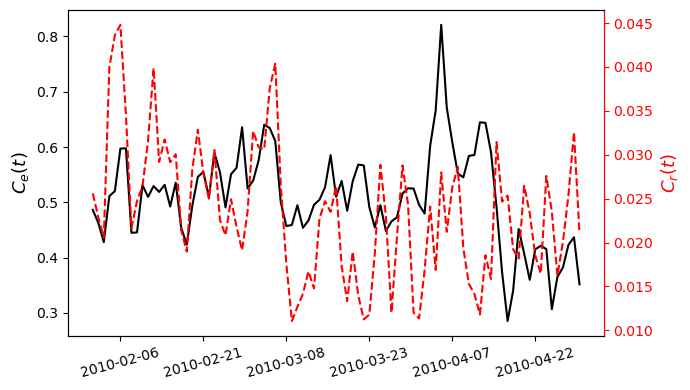

In [38]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax.plot(range(89), CeC.values, 'k', label=r"$C_e(t)$")
ax2.plot(range(89), CrC.values, 'r--', label=r"$C_r(t)$")
ax.set_xticks(np.arange(89)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
ax2.spines['right'].set_color('red')
# ax.legend(loc='lower left', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"$C_e(t)$", fontsize=13)
ax2.set_ylabel(r"$C_r(t)$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/eNATL60_region%02d_Cs.pdf' % reg))

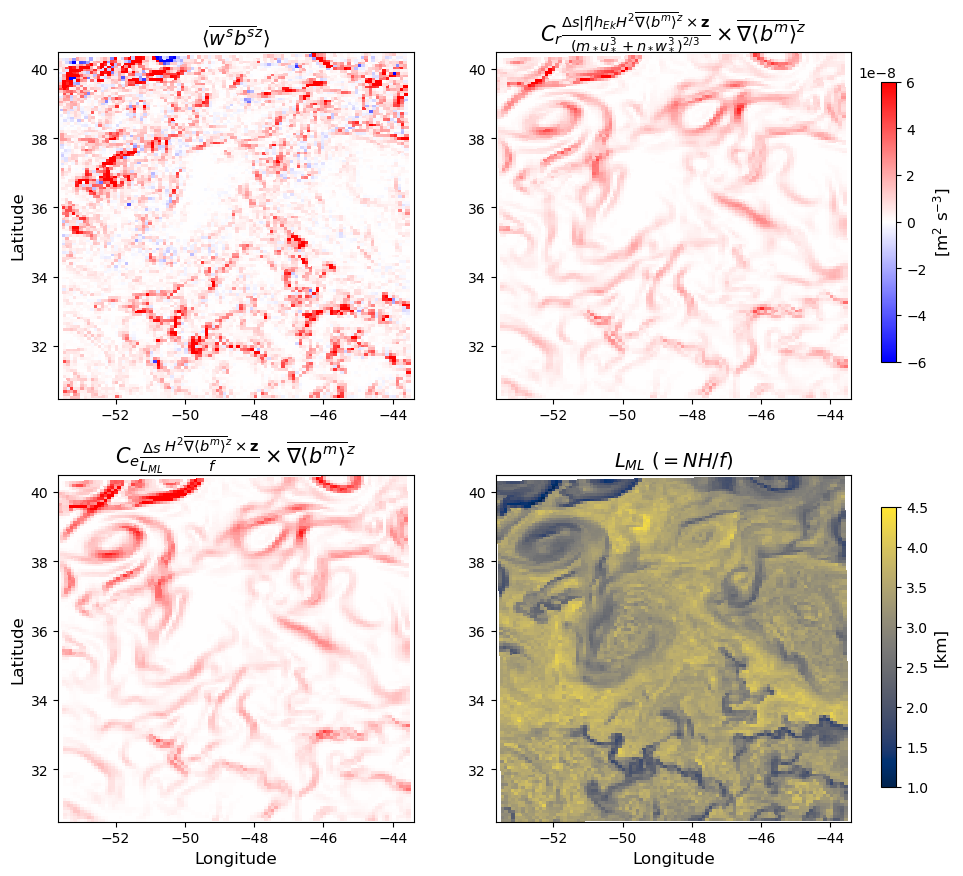

In [42]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im1 = axes[0,0].pcolor(lonC, latC, dsC.WsBs.where(Db>2e2).isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.6e-7, vmax=.6e-7
                      )
im2 = axes[0,1].pcolor(lonC, latC, (bod*CrC).where(Db>2e2).isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.6e-7, vmax=.6e-7
                      )
im3 = axes[1,0].pcolor(lonC, latC, (bff*CeC).where(Db>2e2).isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.6e-7, vmax=.6e-7
                      )
im4 = axes[1,1].pcolor(lonC, latC, Lf_oldb.where(Db>2e2).isel(time=0)*1e-3, 
                 cmap='cividis', rasterized=True,
                 vmin=1., vmax=4.5e0
                 )

axes[0,0].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[0,1].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1,0].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1,1].pcolor(dss.lon.data, dss.lat.data, 
           ds.maskC.where(ds.maskC==0.).isel(Z=0),
           cmap='binary', vmin=-1, vmax=2, rasterized=True)

axes[0,0].set_title(r"$\langle\overline{w^sb^s}^{z}\rangle$", fontsize=14)
axes[0,1].set_title(
r"$C_r\frac{\Delta s|f|h_{Ek}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=15)
axes[1,0].set_title(
r"$C_e\frac{\Delta s}{L_{ML}}\frac{H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{f} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=15)
axes[1,1].set_title(r"$L_{ML}\ (= NH/f)$", fontsize=14)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=0.22, wspace=.18)
cbaxes1 = fig.add_axes([0.88, 0.57, 0.014, 0.28]) 
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbaxes1)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbaxes4 = fig.add_axes([0.88, 0.145, 0.014, 0.28]) 
cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbaxes4)
cbar4.set_label(r"[km]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/eNATL60_MLI_region%02d.pdf' % reg))

In [77]:
Cbod = (bod*CrC).where(Db>2e2)
Cbff = (bff*CeC).where(Db>2e2)
WsBs = dsC.WsBs.where(Db>2e2)
Cbod.name = 'Bodner'
Cbff.name = 'BFF'
WsBs.name = 'Submeso'

In [78]:
xhist_bod = xhist(Cbod.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
xhist_bff = xhist(Cbff.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()

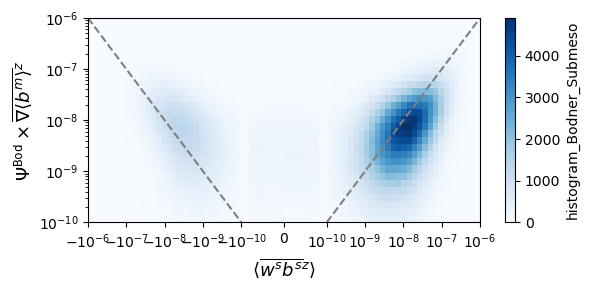

In [79]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_bod.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\Psi^{\tt Bod}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCr-hist_region%02d.pdf' % reg))

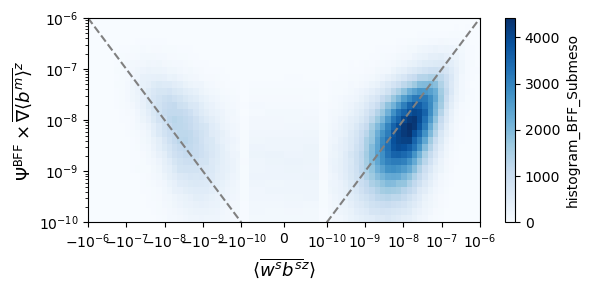

In [80]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_bff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\Psi^{\tt BFF}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCe-hist_region%02d.pdf' % reg))

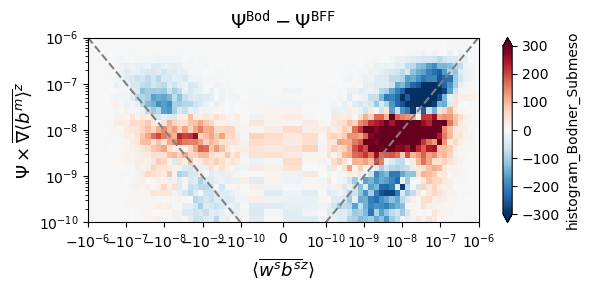

In [81]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

(xhist_bod - xhist_bff.data).plot(ax=ax, cmap='RdBu_r', vmax=3e2, vmin=-3e2)

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\Psi\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_title(r"$\Psi^{\tt Bod} - \Psi^{\tt BFF}$", fontsize=14)

plt.savefig(op.join(sdir,'Figs/eNATL60-Bod-BFF-hist_region%02d.pdf' % reg))

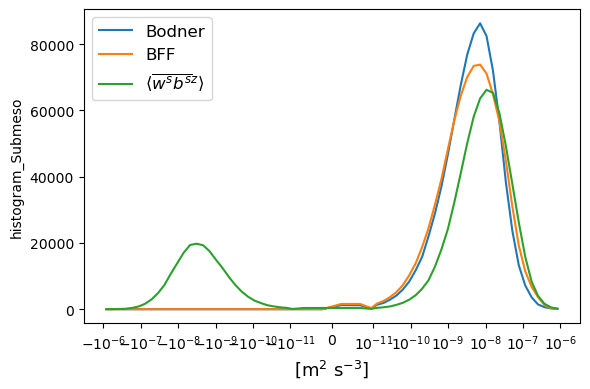

In [84]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

xhist(Cbod.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"Bodner")
xhist(Cbff.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"BFF")
xhist(WsBs.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,30)))))
           ]
     ).plot(ax=ax, label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
plt.savefig(op.join(sdir,'Figs/eNATL60-wb-1Dhist_region%02d.pdf' % reg))